## 1. Credit card applications
<p>Commercial banks on a daily basis receive <em>a lot</em> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated using machine learning and pretty much every commercial bank does so nowadays. In this notebook, we will build a prediction system for automatic credit card approvals using machine learning techniques, just like the real banks do.</p>
<p><img src="https://assets.datacamp.com/production/project_558/img/credit_card.jpg" alt="Credit card being held in hand"></p>
<p>We'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:</p>
<ul>
<li>First, we will start by loading and viewing the dataset.</li>
<li>We will analyze the dataset for numerical and non-numerical values, if it contains values between different ranges and if it has any missing values.</li>
<li>We will then preprocess the dataset to ensure that we are only feeding numerical values to the machine learning model for predicitons.</li>
<li>Finally, we will build a machine learning model that can predict if an individual's application for a credit card will be accepted or not.</li>
<li> Source: <a href="https://projects.datacamp.com/projects/558">Datacamp Project</a></li>  
<li> I have extended the project by including visualizations and correlation analysis.
</ul>
<p>First, loading and viewing the dataset. We find that since this data is confidential, the contributor of the dataset has anonymized the feature names.</p>

In [1]:
# !pip install seaborn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# Loading the dataset
cc_apps = pd.read_csv('dataset/cc_approvals.data', header=None)

# Inspect data
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


In [4]:
cc_apps[15].value_counts()

-    383
+    307
Name: 15, dtype: int64

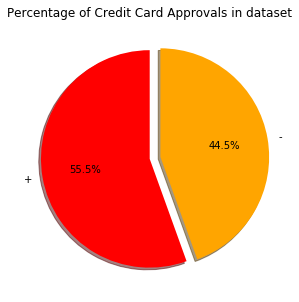

In [5]:
# lets visualize the target with a pie chart
# '+' represents approved and '-' represents rejection
data_size = cc_apps[15].value_counts(sort=True)
colors = ['red','orange']
rcParams['figure.figsize'] = 5,5

# For plotting
labels = '+', '-'
explode = (0, 0.1) 
plt.pie(data_size, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90,)
plt.title('Percentage of Credit Card Approvals in dataset')
plt.show()

## 2. Inspecting the applications
<p>The features of this dataset have been anonymized to protect the privacy, but <a href="http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html">this blog</a> gives us a pretty good overview of the probable features. The features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives us a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>
<p>We see that there are numeric as well as non-numeric columns in the data. We would need to preprocess them to convert them to have numeric values. We would also need to see if there are any other issues which needs to be fixed. </p>
<p>Important thing to note is the target variable is ApprovalStatus whose values are '+' and '-' denoting approved and denied credit card status. We would need to convert the symbols to numerical values 1 and 0.  </p>

In [6]:
# Print summary statistics
cc_apps_description = cc_apps.describe()
print(cc_apps_description)

print("\n")

# Print DataFrame information
cc_apps_info = cc_apps.info()
print(cc_apps_info)

print("\n")

# Inspect missing values in the dataset
cc_apps.tail(17)

               2           7          10             14
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 no

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
673,?,29.50,2.000,y,p,e,h,2.000,f,f,0,f,g,00256,17,-
674,a,37.33,2.500,u,g,i,h,0.210,f,f,0,f,g,00260,246,-
675,a,41.58,1.040,u,g,aa,v,0.665,f,f,0,f,g,00240,237,-
676,a,30.58,10.665,u,g,q,h,0.085,f,t,12,t,g,00129,3,-
677,b,19.42,7.250,u,g,m,v,0.040,f,t,1,f,g,00100,1,-
678,a,17.92,10.210,u,g,ff,ff,0.000,f,f,0,f,g,00000,50,-
679,a,20.08,1.250,u,g,c,v,0.000,f,f,0,f,g,00000,0,-
680,b,19.50,0.290,u,g,k,v,0.290,f,f,0,f,g,00280,364,-
681,b,27.83,1.000,y,p,d,h,3.000,f,f,0,f,g,00176,537,-
682,b,17.08,3.290,u,g,i,v,0.335,f,f,0,t,g,00140,2,-


## 3. Handling the missing values (part i)
<p>As we see above:</p>
<ul>
<li>This dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features 2, 7, 10 and 14 contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values between different ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of in this task. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output.</li>
</ul>
<p>We've uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged.</p>
<p>Now, let's temporarily replace these missing value question marks with NaN.</p>

In [7]:
# Inspecting missing values in the dataset
print('Before', cc_apps.tail(17))

# Replace the '?'s with NaN
cc_apps = cc_apps.replace('?', np.nan)

# Inspect the missing values again
print('After', cc_apps.tail(17))

Before     0      1       2  3  4   5   6      7  8  9   10 11 12     13   14 15
673  ?  29.50   2.000  y  p   e   h  2.000  f  f   0  f  g  00256   17  -
674  a  37.33   2.500  u  g   i   h  0.210  f  f   0  f  g  00260  246  -
675  a  41.58   1.040  u  g  aa   v  0.665  f  f   0  f  g  00240  237  -
676  a  30.58  10.665  u  g   q   h  0.085  f  t  12  t  g  00129    3  -
677  b  19.42   7.250  u  g   m   v  0.040  f  t   1  f  g  00100    1  -
678  a  17.92  10.210  u  g  ff  ff  0.000  f  f   0  f  g  00000   50  -
679  a  20.08   1.250  u  g   c   v  0.000  f  f   0  f  g  00000    0  -
680  b  19.50   0.290  u  g   k   v  0.290  f  f   0  f  g  00280  364  -
681  b  27.83   1.000  y  p   d   h  3.000  f  f   0  f  g  00176  537  -
682  b  17.08   3.290  u  g   i   v  0.335  f  f   0  t  g  00140    2  -
683  b  36.42   0.750  y  p   d   v  0.585  f  f   0  f  g  00240    3  -
684  b  40.58   3.290  u  g   m   v  3.500  f  f   0  t  s  00400    0  -
685  b  21.08  10.085  y  p   e

In [8]:
# Number of a, b values in 0th column
cc_apps[0].value_counts()

b    468
a    210
Name: 0, dtype: int64

In [9]:
cc_apps.isnull().sum()

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64

## 4. Handling the missing values (part ii)
<p>We have replaced all the question marks with NaNs. 
<p>An important question here is <em>why are we giving so much importance to missing values</em>? Can't they be just ignored? Answer is: Ignoring missing values can heavily affect the performance of a machine learning model. While ignoring the missing values our machine learning model may miss out on information about the dataset that may be useful for its training. Then, there are many models which cannot handle missing values implicitly such as LDA. </p>
<p> We see above that columns 0, 1, 3, 4, 5, 6 and 13 have non-numeric values and we would need to impute the missing values in those columns with the most frequent values present in the respective columns. </p>

In [10]:
# Iterate over each column of cc_apps
for col in cc_apps:
    # Check if the column is of object type
    if cc_apps[col].dtypes == 'object':
        # Impute with the most frequent value
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])

# Count the number of NaNs in the dataset and print the counts to verify
cc_apps.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

## 6. Preprocessing the data (part i)
<p>We see from above that we don't have any missing values and that's great.</p>
<p>There is still some minor but essential data preprocessing needed before we proceed towards building our machine learning model. We are going to divide these remaining preprocessing steps into three main tasks:</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Split the data into train and test sets. </li>
<li>Scale the feature values to a uniform range.</li>
</ol>
<p>First, we will be converting all the non-numeric values into numeric ones. We do this because not only it results in a faster computation but also many machine learning models (like random forest, XGBoost,etc) (and especially the ones developed using scikit-learn) require the data to be in a strictly numeric format. We will do this by using a technique called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">label encoding</a>.</p>

In [11]:
cc_apps = cc_apps.apply(LabelEncoder().fit_transform)
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,156,0,2,1,13,8,30,1,1,1,0,0,68,0,0
1,0,328,93,2,1,11,4,65,1,1,6,0,0,11,119,0
2,0,89,16,2,1,11,4,36,1,0,0,0,0,96,140,0
3,1,125,46,2,1,13,8,73,1,1,5,1,0,31,3,0
4,1,43,109,2,1,13,8,41,1,0,0,0,2,37,0,0


### Correlation Analysis

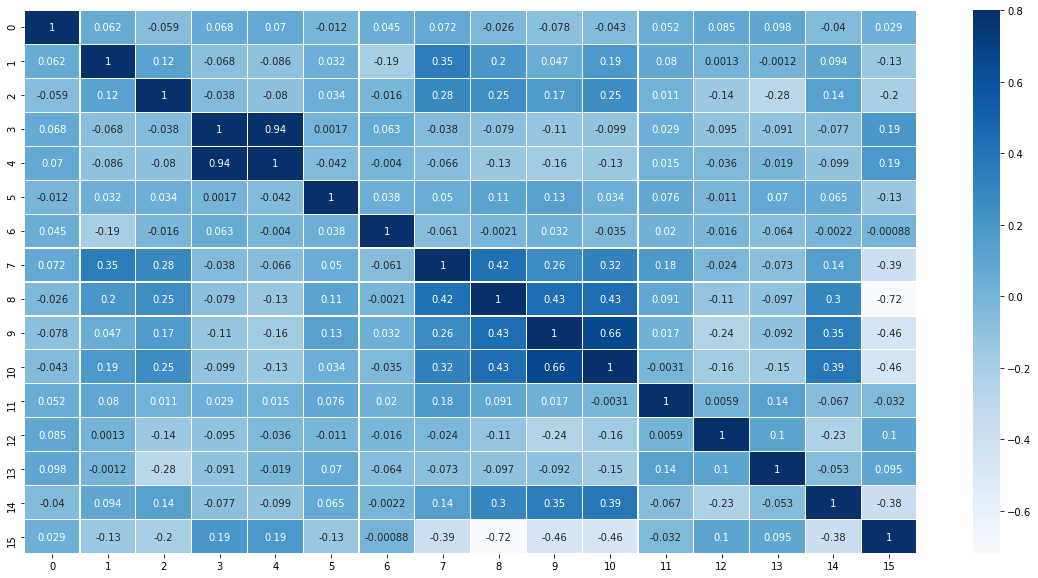

In [12]:
# To see the correlation between variables, we will use Pearson coefficient and use heatmap for visualization
# Correlation Plot
corr_matrix = cc_apps.corr()
f, ax = plt.subplots(figsize=(20, 10))

#Draw the heatmap using seaborn
sns.heatmap(corr_matrix, linewidths=0.1, cmap = plt.cm.Blues, linecolor = 'White', vmax=0.8, annot=True)

In [13]:
cc_apps.corr()[15] 

0     0.028934
1    -0.133304
2    -0.202400
3     0.191431
4     0.187520
5    -0.130026
6    -0.000877
7    -0.385006
8    -0.720407
9    -0.458301
10   -0.462489
11   -0.031625
12    0.100867
13    0.094851
14   -0.381625
15    1.000000
Name: 15, dtype: float64

In [110]:
cc_apps.corr()[15].abs() > 0.15

0     False
1     False
2      True
3      True
4      True
5     False
6     False
7      True
8      True
9      True
10     True
11    False
12    False
13    False
14     True
15     True
Name: 15, dtype: bool

We will select the features with absolute correlation value greater than 0.15 wrt to the target variable.
Hence, features for training will be 2,3,4,7,8,9,10,14

## 7. Splitting the dataset into train and test sets
<p>We have successfully converted all the non-numeric values to numeric ones.</p>
<p>Now, we will split our data into training set and testing set. We will use stratified split to keep the same percentage of approved and rejected applications as in the full dataset. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.</p>
<p>Also, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. We should drop them to design our machine learning model with the best set of features. In Data Science literature, this is often referred to as <em>feature selection</em>. </p>

In [111]:
feature_names = [2,3,4, 7,8,9,10,14]

In [112]:
# We will not consider the features like 11, 13 which are not important and do not help in model prediction.
# Segregate features and labels into separate variables
X = cc_apps[feature_names]
y = cc_apps[[15]]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                y, stratify = y, test_size=0.33, random_state=42)

In [113]:
y_train

,15
41,0
675,1
31,0
624,1
303,1
...,...
101,1
416,1
569,0
290,1


In [114]:
np.count_nonzero(y_train == 1)

256

In [115]:
np.count_nonzero(y_train == 0)

206

In [116]:
np.count_nonzero(y_test==1)

127

In [117]:
np.count_nonzero(y_test==0)

101

## 8. Preprocessing the data (part ii)
<p>Training and testing sets are ready now. We are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data. </p>
<p>Now, let's try to understand what these scaled values mean in the real world. Let's use <code>CreditScore</code> as an example. The credit score of a person is their creditworthiness based on their credit history. The higher this number, the more financially trustworthy a person is considered to be. So, a <code>CreditScore</code> of 1 is the highest since we're rescaling all the values to the range of 0-1.</p>

In [118]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Instantiate MinMaxScaler and use it to rescale X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.fit_transform(X_test)

In [119]:
rescaledX_train

array([[0.92417062, 0.66666667, 0.33333333, ..., 1.        , 0.5       ,
        0.79497908],
       [0.1563981 , 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.34728033],
       [0.7014218 , 0.66666667, 0.33333333, ..., 1.        , 0.36363636,
        0.        ],
       ...,
       [0.14218009, 0.66666667, 0.33333333, ..., 1.        , 0.18181818,
        0.72803347],
       [0.11848341, 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.34123223, 0.66666667, 0.33333333, ..., 1.        , 0.04545455,
        0.09205021]])

In [120]:
rescaledX_test

array([[0.55140187, 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.21212121],
       [0.02336449, 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       [0.09813084, 0.66666667, 0.33333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.91121495, 0.66666667, 0.33333333, ..., 1.        , 0.66666667,
        0.80952381],
       [0.40186916, 0.66666667, 0.33333333, ..., 1.        , 0.14285714,
        0.81818182],
       [0.03738318, 0.66666667, 0.33333333, ..., 1.        , 0.52380952,
        0.20779221]])

## 9. Fitting a logistic regression model to the train set
<p>Essentially, predicting if a credit card application will be approved or not is a <a href="https://en.wikipedia.org/wiki/Statistical_classification">classification</a> task. <a href="http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names">According to UCI</a>, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved. </p>
<p>This gives us a benchmark. A good machine learning model should be able to accurately predict the status of the applications with respect to these statistics.</p>
<p>Which model should we pick? Because of this correlation between the features, we'll take advantage of the fact that generalized linear models perform well in these cases. Let's start our machine learning modeling with a Logistic Regression model (a generalized linear model).</p>

In [121]:
rescaledX_train = pd.DataFrame(rescaledX_train, columns = feature_names)
rescaledX_test = pd.DataFrame(rescaledX_test, columns = feature_names)

In [122]:
rescaledX_train

,2,3,4,7,8,9,10,14
0,0.924171,0.666667,0.333333,0.692308,1.0,1.0,0.500000,0.794979
1,0.156398,0.666667,0.333333,0.130769,0.0,0.0,0.000000,0.347280
2,0.701422,0.666667,0.333333,0.815385,1.0,1.0,0.363636,0.000000
3,0.123223,1.000000,1.000000,0.130769,0.0,0.0,0.000000,0.000000
4,0.336493,0.666667,0.333333,0.015385,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
457,0.943128,1.000000,1.000000,0.576923,1.0,0.0,0.000000,0.000000
458,0.018957,1.000000,1.000000,0.023077,0.0,0.0,0.000000,0.179916
459,0.142180,0.666667,0.333333,0.146154,1.0,1.0,0.181818,0.728033
460,0.118483,0.666667,0.333333,0.100000,0.0,0.0,0.000000,0.000000


In [123]:
# Instantiate a LogisticRegression classifier with default parameter values
logreg = LogisticRegression()

# Fit logreg to the train set
logreg.fit(rescaledX_train,y_train.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 10. Making predictions and evaluating performance
<p>But how well does our model perform? </p>
<p>We will now evaluate our model on the test set with respect to <a href="https://developers.google.com/machine-learning/crash-course/classification/accuracy">classification accuracy</a>. But we will also take a look the model's <a href="http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/">confusion matrix</a>. In the case of predicting credit card applications, it is equally important to see if our machine learning model is able to predict the approval status of the applications as denied that originally got denied. If our model is not performing well in this aspect, then it might end up approving the application that should have been approved. The confusion matrix helps us to view our model's performance from these aspects.  </p>

In [124]:
# Use logreg to predict instances from the test set and store it
y_pred = logreg.predict(rescaledX_test)

# Get the accuracy score of logreg model and print it
print("Accuracy of logistic regression classifier: ", accuracy_score(y_test,y_pred))

# Print the confusion matrix of the logreg model
print('Confusion matrix: ', confusion_matrix(y_test,y_pred))

Accuracy of logistic regression classifier:  0.8464912280701754
Confusion matrix:  [[ 88  13]
 [ 22 105]]


## 11. Grid searching and making the model perform better
<p>Our model was pretty good! It was able to yield an accuracy score of almost 85%.</p>
<p>For the confusion matrix, the first element of the of the first row of the confusion matrix denotes the true negatives meaning the number of negative instances (denied applications) predicted by the model correctly. And the last element of the second row of the confusion matrix denotes the true positives meaning the number of positive instances (approved applications) predicted by the model correctly.</p>
<p>Let's see if we can do better. We can perform a <a href="https://machinelearningmastery.com/how-to-tune-algorithm-parameters-with-scikit-learn/">grid search</a> of the model parameters to improve the model's ability to predict credit card approvals.</p>
<p><a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">scikit-learn's implementation of logistic regression</a> consists of different hyperparameters but we will grid search over the following two:</p>
<ul>
<li>tol</li>
<li>max_iter</li>
</ul>

In [125]:
# Define the grid of values for tol and max_iter
tol = [0.01,0.001, 0.0001]
max_iter = [100,150,200]

# Create a dictionary where tol and max_iter are keys and the lists of their values are corresponding values
param_grid = dict(tol=tol, max_iter=max_iter)

## 12. Finding the best performing model
<p>We have defined the grid of hyperparameter values and converted them into a single dictionary format which <code>GridSearchCV()</code> expects as one of its parameters. Now, we will begin the grid search to see which values perform best.</p>
<p>We will instantiate <code>GridSearchCV()</code> with our earlier <code>logreg</code> model with all the data we have. Instead of passing train and test sets separately, we will supply <code>X</code> (scaled version) and <code>y</code>. We will also instruct <code>GridSearchCV()</code> to perform a <a href="https://www.dataschool.io/machine-learning-with-scikit-learn/">cross-validation</a> of five folds.</p>
<p>We'll end the notebook by storing the best-achieved score and the respective best parameters.</p>
<p>While building this credit card predictor, we tackled some of the most widely-known preprocessing steps such as <strong>scaling</strong>, <strong>label encoding</strong>, and <strong>missing value imputation</strong>, correlation analysis. We finished with some <strong>machine learning</strong> to predict if a person's application for a credit card would get approved or not given some information about that person.</p>

In [126]:
# Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)

# Use scaler to rescale X and assign it to rescaledX
rescaledX = scaler.fit_transform(X)

# Fit data to grid_model
grid_model_result = grid_model.fit(rescaledX, y.values.ravel())

# Summarize results
best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.840580 using {'max_iter': 100, 'tol': 0.001}


### Few ideas to try:
1. We can try random forest and xgboost.
2. We can use ensemble method called majority voting to predict the final label using the predictions from the three
machine learning methods.